In [ ]:
# import and install dependensies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.core.reshape.tile import to_datetime
!pip install prophet
from prophet import Prophet

## Data Preparation and Preprocessing

In [ ]:
# Reading data into DataFrame
cab_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataGlaciers/Cab_Data.csv')
city = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataGlaciers/City.csv')
customer_id = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataGlaciers/Customer_ID.csv')
transaction = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataGlaciers/Transaction_ID.csv')
holidays = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataGlaciers/holidays.csv')

# Set the display option to show two decimal places for floating-point numbers
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
# Merge the DataFrames using pandas
df = pd.merge(cab_data, transaction, on= 'Transaction ID')
df = pd.merge(df, customer_id, on='Customer ID')
# Convert Date of Trave to datetime format
df['Date of Travel'] = pd.to_datetime(df['Date of Travel'])

holidays['date'] = pd.to_datetime(holidays['date'])

# Merge DataFrames based on 'Date' column
df = pd.merge(df, holidays, left_on='Date of Travel', right_on='date', how='left')

# Create 'Is Holiday' column and mark 'Yes' where there is a match
df['Is Holiday'] = df['date'].apply(lambda x: 'Yes' if pd.notnull(x) else 'No')

# Drop unnecessary columns
df = df.drop(['date', 'holiday'], axis=1)

# Convert Transaction ID column to string format
df['Transaction ID'] = df['Transaction ID'].astype(str)

# Convert Year column to string format
df['Year'] = df['Year'].astype(str)

# Convert Customer IDcolumn to string format
df['Customer ID'] = df['Customer ID'].astype(str)

# Define age group bins and labels
bins = [25, 35, 45, 55, 65, 75, 85]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']

# Create a new column 'Age group'
df['Age Group'] = pd.cut(df['Age'], bins=bins, labels=labels, include_lowest=True)

# Define Income Range bins and labels
bins = [5000, 10000, 20000, 30000, 40000, 50000]
labels = ['2-5k', '6-10k', '11-20k', '21-30k', '31-40k']

# Create a new column 'Income Range'
df['Income Range'] = pd.cut(df['Income (USD/Month)'], bins=bins, labels=labels, include_lowest=True)


# Profit made on each trip
df['Profit'] = df['Price Charged']-df['Cost of Trip']

# Extract Month
df['Month'] = df['Date of Travel'].dt.month_name()

# Extract Day
df['Day'] = df['Date of Travel'].dt.day

# Extract Day of the Week
df['Day_of_Week'] = df['Date of Travel'].dt.day_name()

# Convert Day column to string format
df['Day'] = df['Day'].astype(str)

df = df.sort_values('Date of Travel', ascending=True)

# Calculate profit per kilometer
df['Profit per KM'] = df['Profit'] / df['KM Travelled']


In [ ]:
#Filtering out less importantant columns
df = df[[
        'Transaction ID', 'Date of Travel', 'Company','City','Customer ID', 'Payment_Mode',
         'Gender', 'Age Group', 'Income Range', 'Is Holiday', 'MonthYear', 'Year',
         'Month','Day', 'Day_of_Week','KM Travelled', 'Price Charged',
         'Cost of Trip', 'Profit', 'Profit per KM'
         ]]

# Calculate the average profit per kilometer
pink_cab_average = df[df['Company'] == 'Pink Cab']['Profit per KM'].mean()
yellow_cab_average = df[df['Company'] == 'Yellow Cab']['Profit per KM'].mean()
overall_profit_average = df['Profit per KM'].mean()

# Calculate total distance travelled
pink_total_km = df[df['Company']=='Pink Cab']['KM Travelled'].sum()
yellow_total_km = df[df['Company']=='Yellow Cab']['KM Travelled'].sum()
total_km = df['KM Travelled'].sum()

# Calculate average KM travelled
pink_average_km = df[df['Company']=='Pink Cab']['KM Travelled'].mean()
yellow_average_km = df[df['Company']=='Yellow Cab']['KM Travelled'].mean()
overall_km_average = df['KM Travelled'].mean()

# Preparing Data for Forcasting using Facebook Prophet
pink_cab_profit = df[df['Company'] == 'Pink Cab'][['Date of Travel', 'Profit']]
yellow_cab_profit = df[df['Company'] == 'Yellow Cab'][['Date of Travel', 'Profit']]
pink_cab_profit = pink_cab_profit.groupby('Date of Travel')['Profit'].sum().reset_index()
yellow_cab_profit = yellow_cab_profit.groupby('Date of Travel')['Profit'].sum().reset_index()
# Renaming columns
pink_cab_profit = pink_cab_profit.rename(columns={'Date of Travel': 'ds', 'Profit': 'y'})
yellow_cab_profit =yellow_cab_profit.rename(columns={'Date of Travel': 'ds', 'Profit':'y'})


## Exploratory Data Analysis

<ipython-input-5-01b98ba11be0>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


<Axes: >

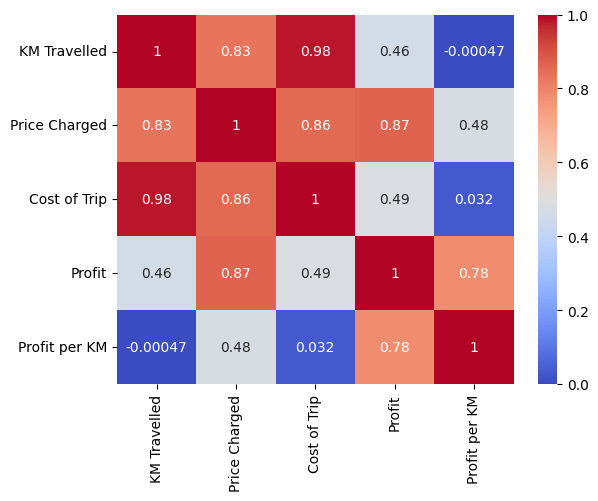

In [ ]:
# Correlation Matrix
correlation = df.corr()

# Heatmap to determine degree of correlation between variables
sns.heatmap(correlation, annot = True, cmap = 'coolwarm')

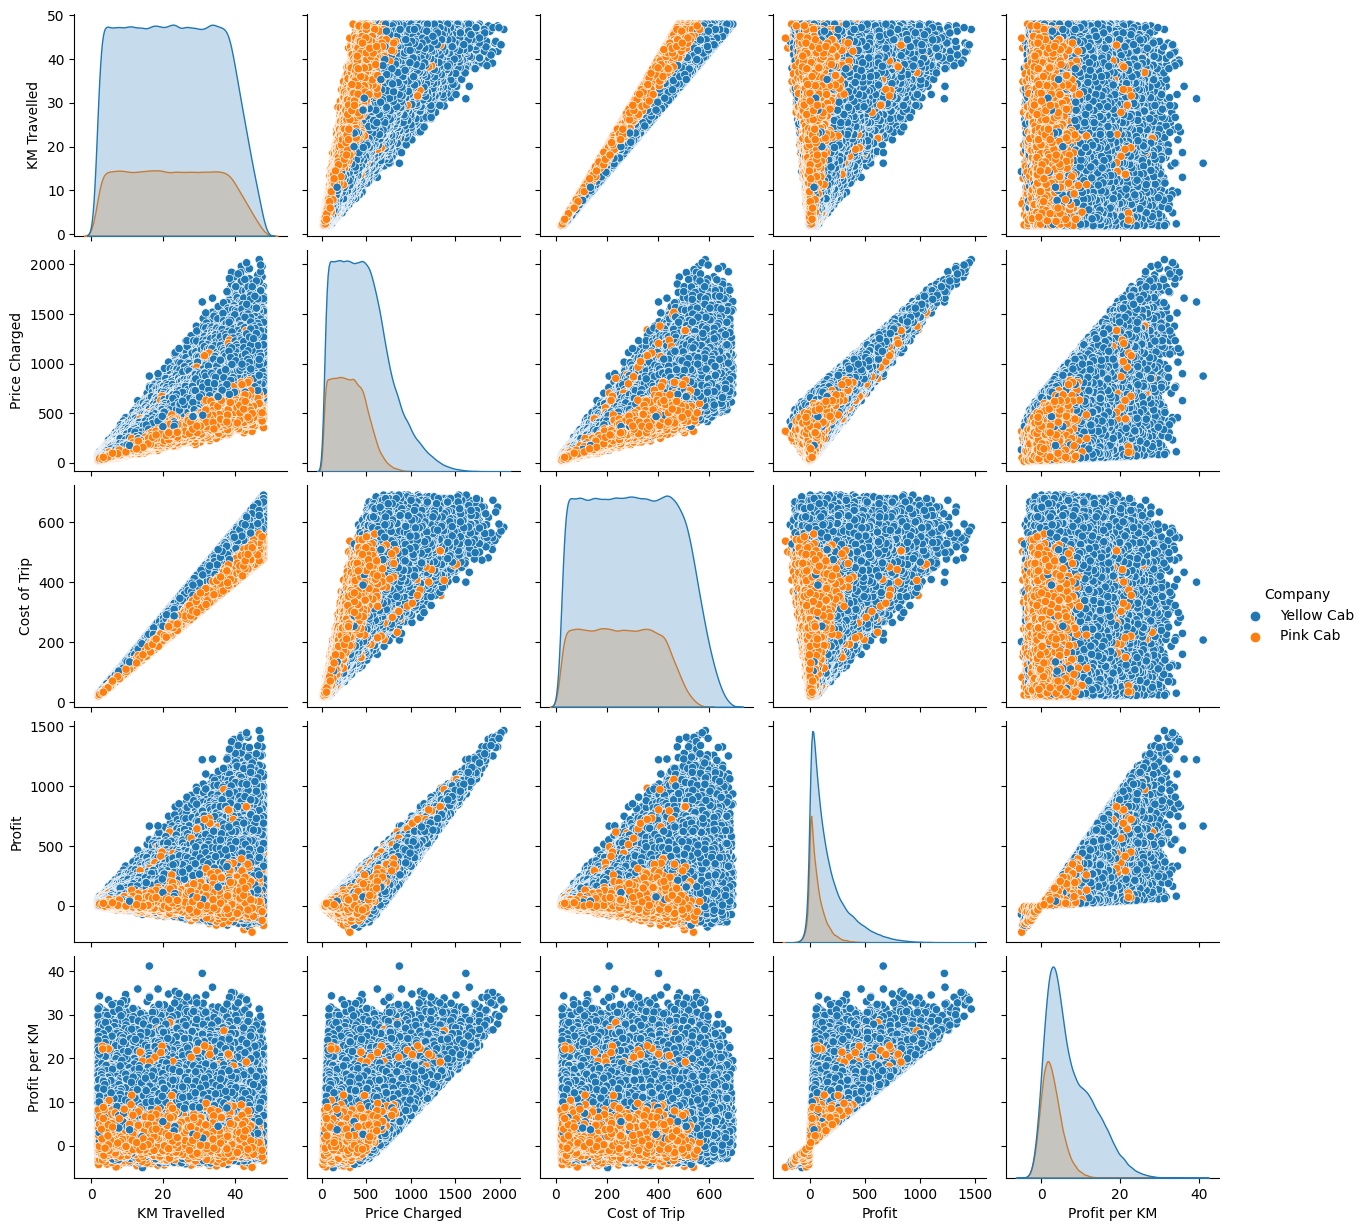

In [ ]:
# Pair plot to determing relationship between variables
sns.pairplot(df, hue = 'Company')

## Data Analysis and Visualization

<Axes: xlabel='City', ylabel='KM Travelled'>

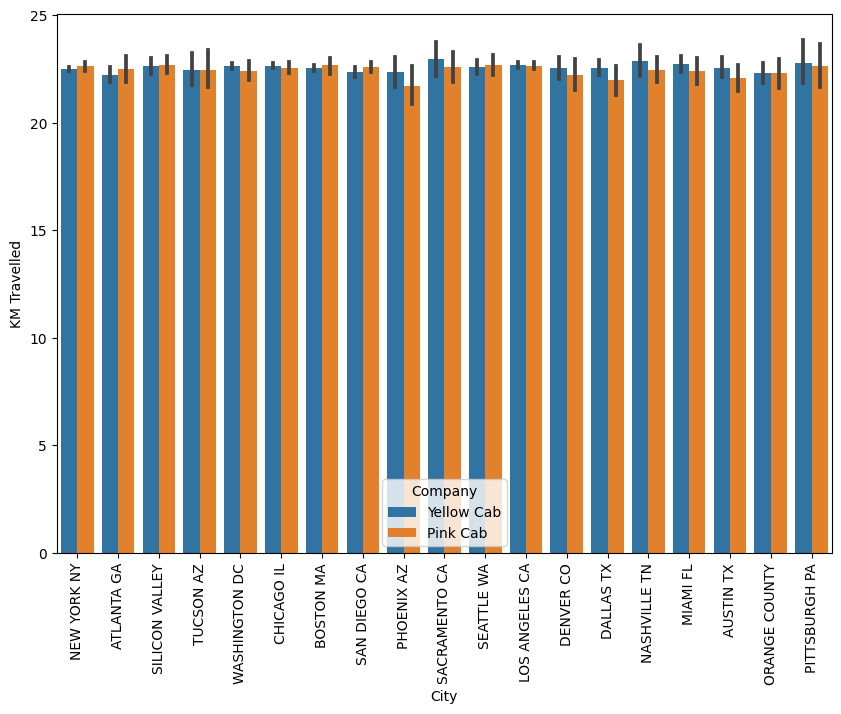

In [ ]:
# Bar chart for KM by Company and City
plt.figure(figsize=(10,7))
# Rotate x-axis labels
plt.xticks(rotation=90)
sns.barplot(x='City', y= 'KM Travelled', hue='Company', data= df)

<Axes: xlabel='City', ylabel='Profit'>

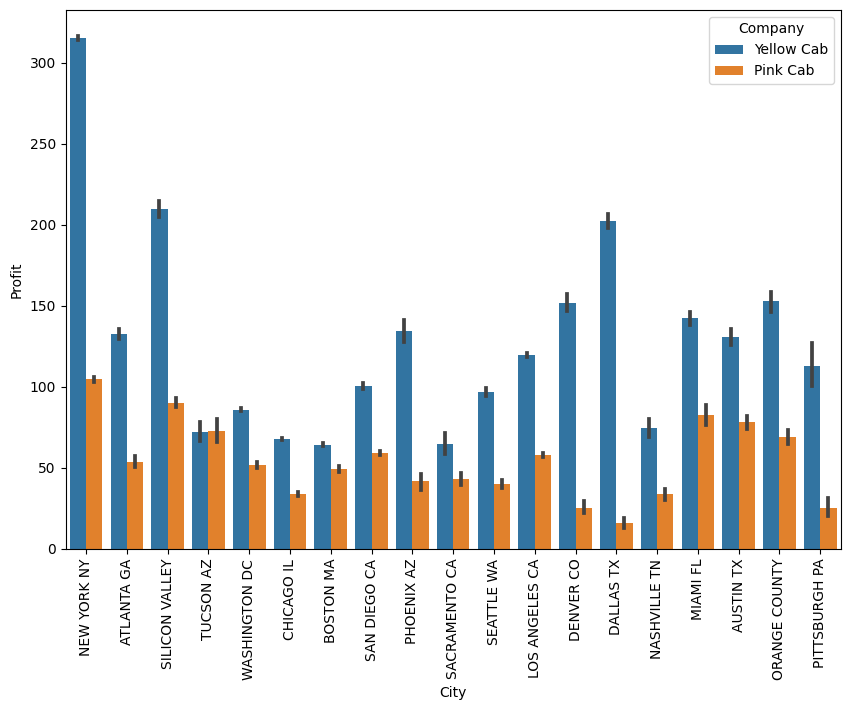

In [ ]:
# Bar chart for profit made by Company and City
plt.figure(figsize=(10,7))
# Rotate x-axis labels
plt.xticks(rotation=90)
sns.barplot(x='City', y= 'Profit', hue='Company', data= df)

<Axes: xlabel='Year', ylabel='KM Travelled'>

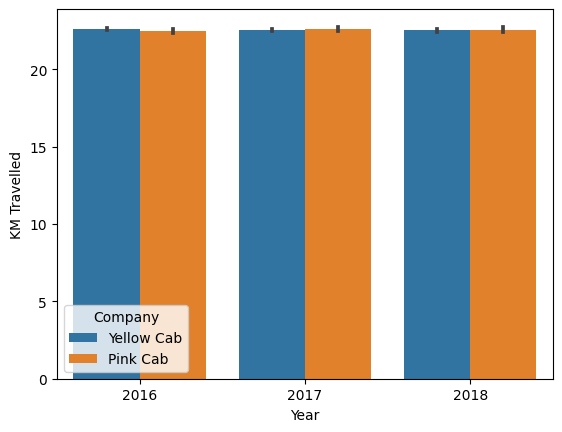

In [ ]:
# Bar plot for Profit by Year and Company
sns.barplot(x='Year', y='KM Travelled', hue='Company', data=df)

<Axes: xlabel='Year', ylabel='Profit'>

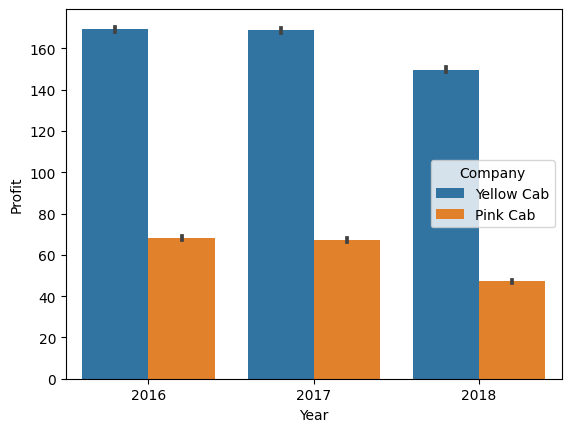

In [ ]:
# Bar plot for yearly profit by company
sns.barplot(x='Year', y='Profit', hue='Company', data=df)

<Axes: xlabel='Income Range', ylabel='KM Travelled'>

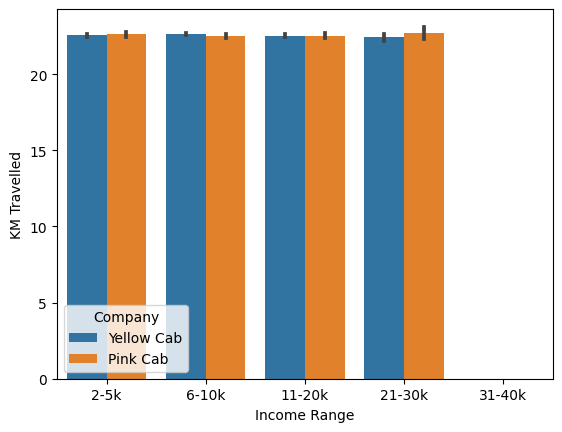

In [ ]:
# Bar plot for distance treavelled yearly by Income Range
sns.barplot(x='Income Range', y='KM Travelled', hue='Company', data=df)

<Axes: xlabel='Income Range', ylabel='Profit'>

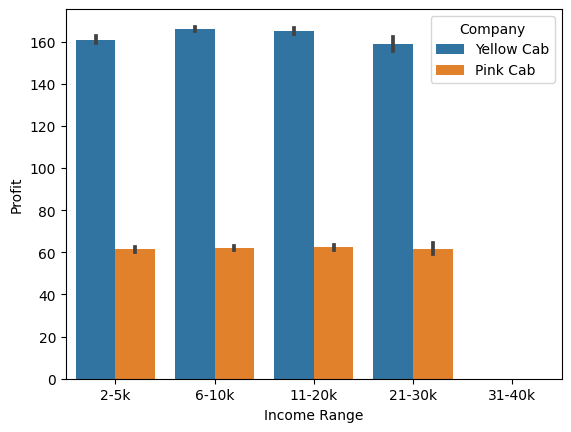

In [ ]:
# Bar plot for yearly profit by Income Range
sns.barplot(x='Income Range', y='Profit', hue='Company', data=df)

<Axes: xlabel='Gender', ylabel='KM Travelled'>

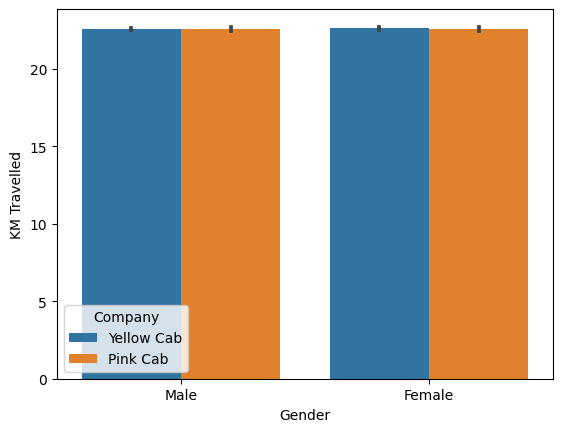

In [ ]:
# Bar plot for distance travelled yearly by Gender
sns.barplot(x='Gender', y='KM Travelled', hue='Company', data=df)

<Axes: xlabel='Gender', ylabel='Profit'>

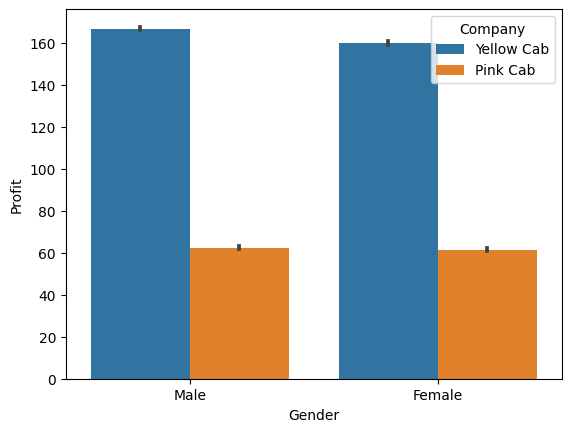

In [ ]:
# Bar plot for yearly profit by Gender
sns.barplot(x='Gender', y='Profit', hue='Company', data=df)

<Axes: xlabel='Age Group', ylabel='KM Travelled'>

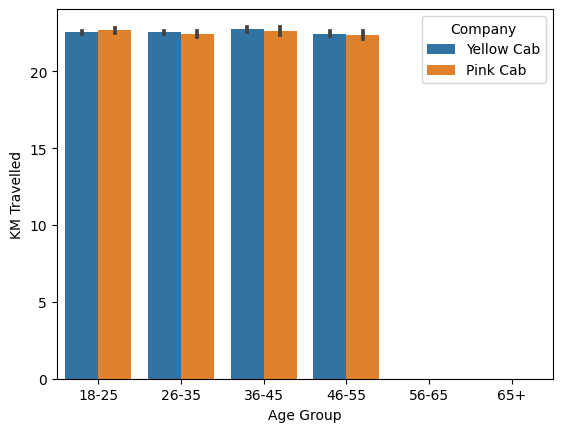

In [ ]:
# Bar plot for distance travelled by Age Group
sns.barplot(x='Age Group', y='KM Travelled', hue='Company', data=df)

<Axes: xlabel='Age Group', ylabel='Profit'>

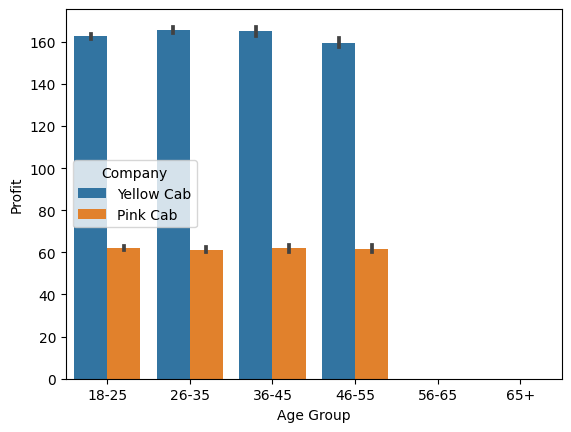

In [ ]:
# Bar plot for profit made by Age Group
sns.barplot(x='Age Group', y='Profit', hue='Company', data=df)

<Axes: xlabel='Payment_Mode', ylabel='KM Travelled'>

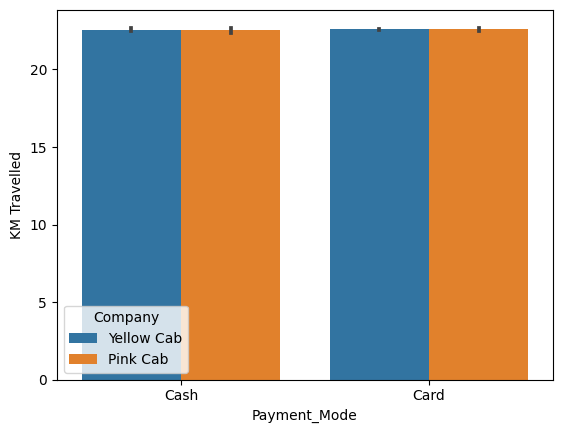

In [ ]:
# Bar plot for distance travelled by Payment Method
sns.barplot(x='Payment_Mode', y='KM Travelled', hue='Company', data=df)

<Axes: xlabel='Payment_Mode', ylabel='Profit'>

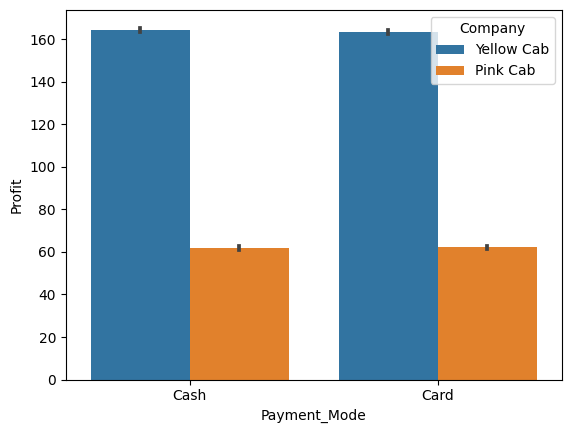

In [ ]:
# Bar plot for Profit made by Payment Method
sns.barplot(x='Payment_Mode', y='Profit', hue='Company', data=df)

<Axes: xlabel='Month', ylabel='KM Travelled'>

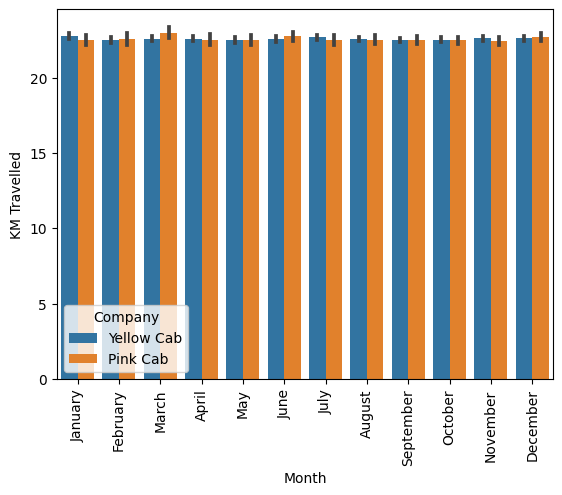

In [ ]:
# Bar plot for distance travelled by Month
plt.xticks(rotation=90)
sns.barplot(x='Month', y='KM Travelled', hue='Company', data=df)

<Axes: xlabel='Month', ylabel='Profit'>

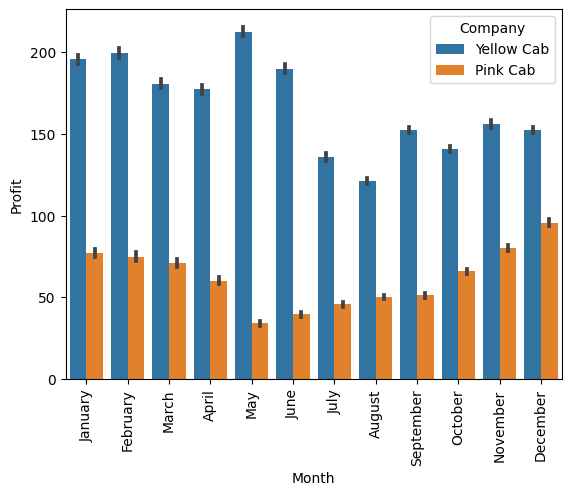

In [ ]:
# Bar plot for Profit made by Month
plt.xticks(rotation=90)
sns.barplot(x='Month', y='Profit', hue='Company', data=df)

<Axes: xlabel='Day_of_Week', ylabel='KM Travelled'>

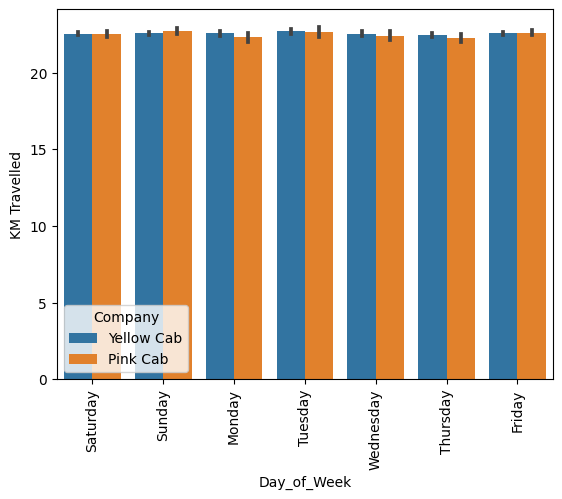

In [ ]:
# Bar plot for distance travelled by Day of the week
plt.xticks(rotation=90)
sns.barplot(x='Day_of_Week', y='KM Travelled', hue='Company', data=df)

<Axes: xlabel='Day_of_Week', ylabel='Profit'>

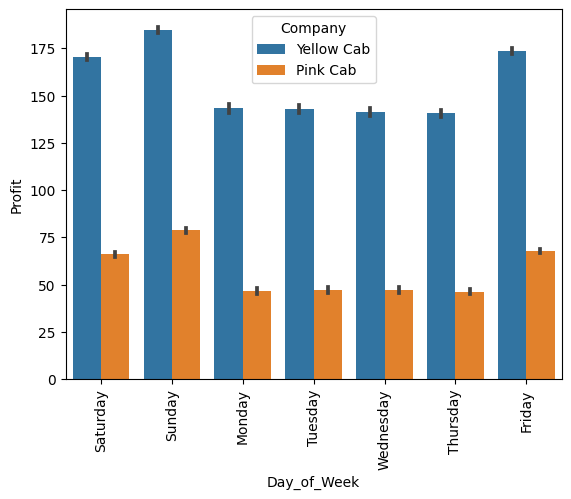

In [ ]:
# Bar plot for Profit made by Day of the week
plt.xticks(rotation=90)
sns.barplot(x='Day_of_Week', y='Profit', hue='Company', data=df)

<Axes: xlabel='Is Holiday', ylabel='KM Travelled'>

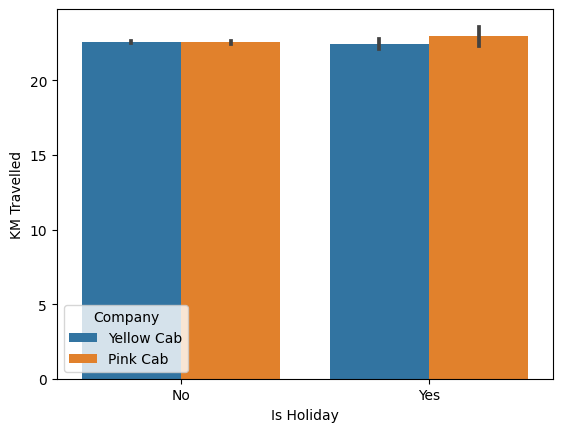

In [ ]:
# Bar plot for distance travelled by Holiday
sns.barplot(x='Is Holiday', y='KM Travelled', hue='Company', data=df)

<Axes: xlabel='Is Holiday', ylabel='Profit'>

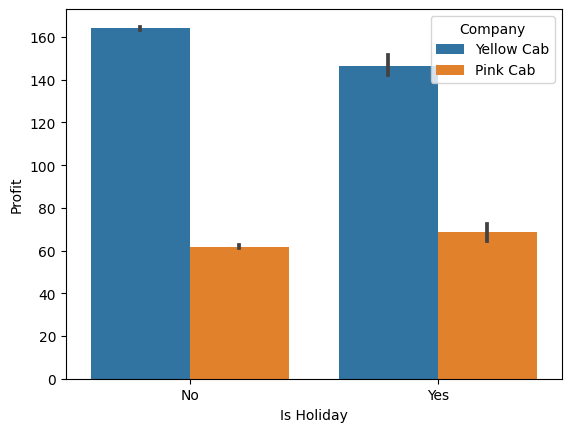

In [ ]:
# Bar plot for Profit made by Holiday
sns.barplot(x='Is Holiday', y='Profit', hue='Company', data=df)

<Axes: xlabel='Day', ylabel='KM Travelled'>

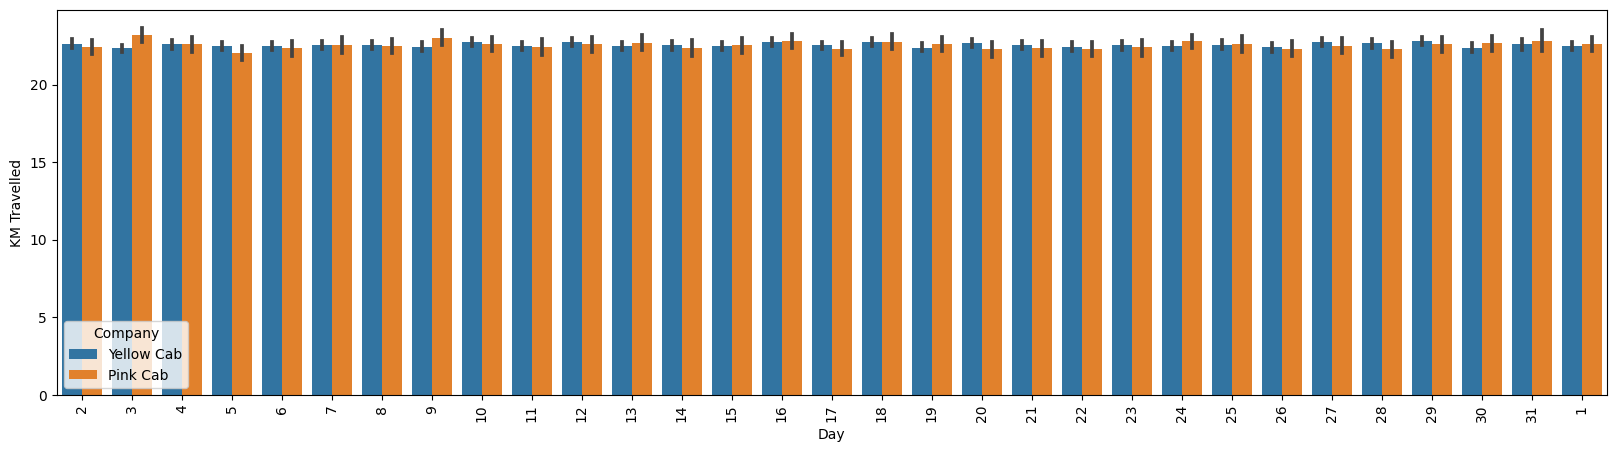

In [ ]:
# Bar plot for distance travelled by Date
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
sns.barplot(x='Day', y='KM Travelled', hue='Company', data=df)

<Axes: xlabel='Day', ylabel='Profit'>

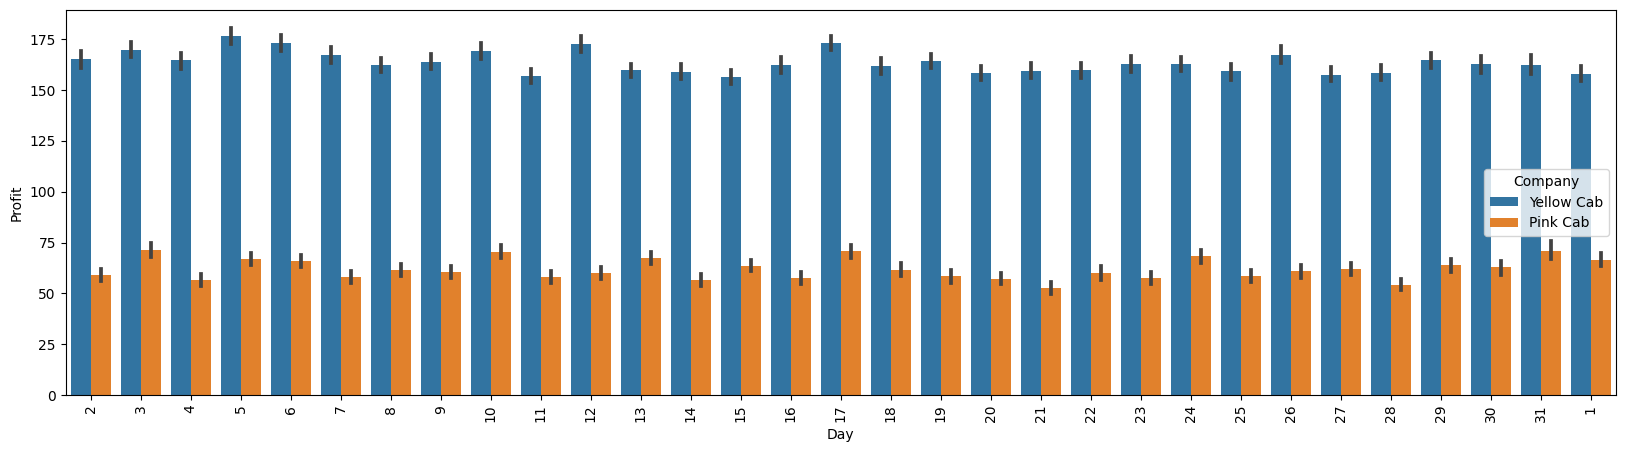

In [ ]:
# Bar plot for Profit made by Date
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
sns.barplot(x='Day', y='Profit', hue='Company', data=df)

In [ ]:
# Number of transactions by Pink Cab and Yellow Cab
num_pink_tran = len(df[df['Company'] == 'Pink Cab'])
num_yellow_tran = len(df[df['Company'] == 'Yellow Cab'])
total_tran = len(df['Transaction ID'])

# Number of Holidays
pink_hols = len(df[(df['Is Holiday']=='Yes') & (df['Company']== 'Pink Cab')])
yellow_hols = len(df[(df['Is Holiday']=='Yes') & (df['Company']== 'Yellow Cab')])
hols_tran = len((df['Is Holiday']=='Yes'))

# Number of customers
pink_customers = df[df['Company']=='Pink Cab']['Customer ID'].nunique()
yellow_customers = df[df['Company']=='Yellow Cab']['Customer ID'].nunique()
total_customers = df['Customer ID'].nunique()


# Create a new DataFrame
columns = ['Name', 'Pink Cab', 'Yellow Cab', 'Total',]
transactions_customers = pd.DataFrame(columns=columns)

# Append a row for 'Number of Transactions'
transactions_customers = transactions_customers.append({
    'Name': 'Number of Transactions',
    'Pink Cab': num_pink_tran,
    'Yellow Cab': num_yellow_tran,
    'Total': total_tran
}, ignore_index=True)

# Append a row for 'Transactions on Holidays'
transactions_customers = transactions_customers.append({
    'Name': 'Transactions on Holidays',
    'Pink Cab': pink_hols,
    'Yellow Cab': yellow_hols,
    'Total': hols_tran
}, ignore_index=True)

# Append a row for 'Number of Customers'
transactions_customers = transactions_customers.append({
    'Name': 'Number of Customers',
    'Pink Cab': pink_customers,
    'Yellow Cab': yellow_customers,
    'Total': total_customers
}, ignore_index=True)

# Append a row for 'Average Profit per KM'
transactions_customers = transactions_customers.append({
    'Name': 'Average Profit per KM',
    'Pink Cab': pink_cab_average,
    'Yellow Cab': yellow_cab_average,
    'Total': overall_profit_average
}, ignore_index=True)

# Append a row for total distance
transactions_customers = transactions_customers.append({
    'Name': 'Total Distance (KM)',
    'Pink Cab': pink_total_km,
    'Yellow Cab': yellow_total_km,
    'Total': total_km
}, ignore_index=True)

# Append a row for 'Average KM'
transactions_customers = transactions_customers.append({
    'Name': 'Average Distance (KM)',
    'Pink Cab': pink_average_km,
    'Yellow Cab': yellow_average_km,
    'Total': overall_km_average
}, ignore_index=True)

# Display the updated DataFrame
transactions_customers


<ipython-input-26-e8591f7dc346>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transactions_customers = transactions_customers.append({
<ipython-input-26-e8591f7dc346>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transactions_customers = transactions_customers.append({
<ipython-input-26-e8591f7dc346>:38: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transactions_customers = transactions_customers.append({
<ipython-input-26-e8591f7dc346>:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transactions_customers = transactions_customers.append({
<ipython-input-26-e8591f7dc346>:54: FutureWarning: The frame.append method is deprecated

,Name,Pink Cab,Yellow Cab,Total
0,Number of Transactions,76255,247155,323410
1,Transactions on Holidays,1529,4490,323410
2,Number of Customers,30865,38486,44888
3,Average Profit per KM,2.74,7.26,6.20
4,Total Distance (KM),1720280.40,5579162.23,7299442.63
5,Average Distance (KM),22.56,22.57,22.57


<Axes: xlabel='Age Group', ylabel='Count'>

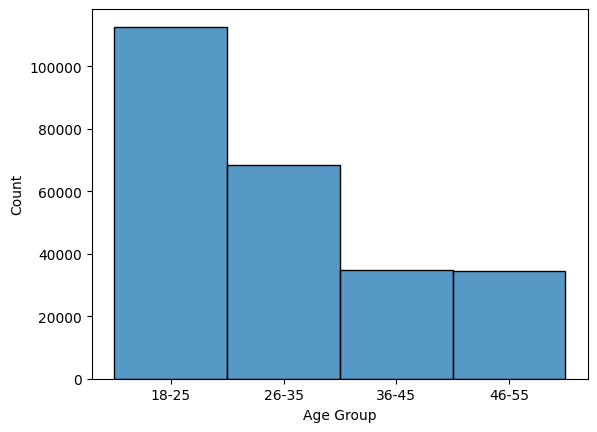

In [ ]:
# Age group distribution
sns.histplot(x='Age Group', data=df)

<Axes: xlabel='Month', ylabel='Count'>

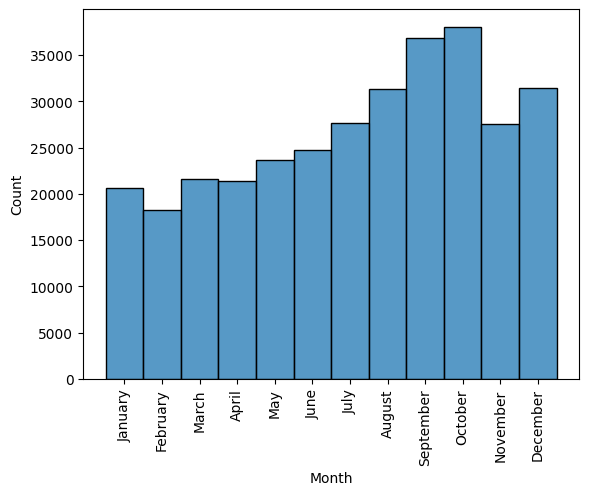

In [ ]:
# Month distribution
plt.xticks(rotation=90)
sns.histplot(x='Month',data=df)

<Axes: xlabel='Year', ylabel='Count'>

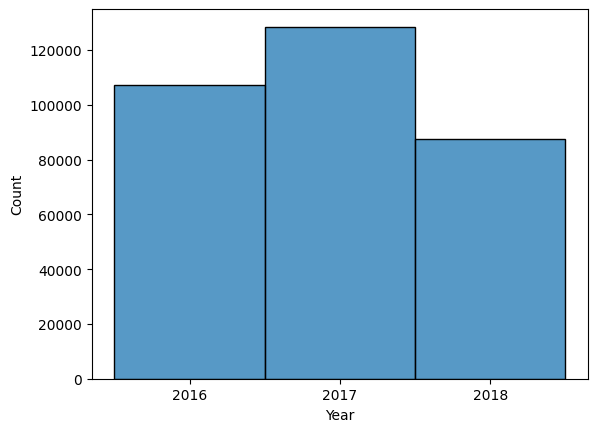

In [ ]:
# Year distribution
sns.histplot(x='Year', data=df)

<Axes: xlabel='Day_of_Week', ylabel='Count'>

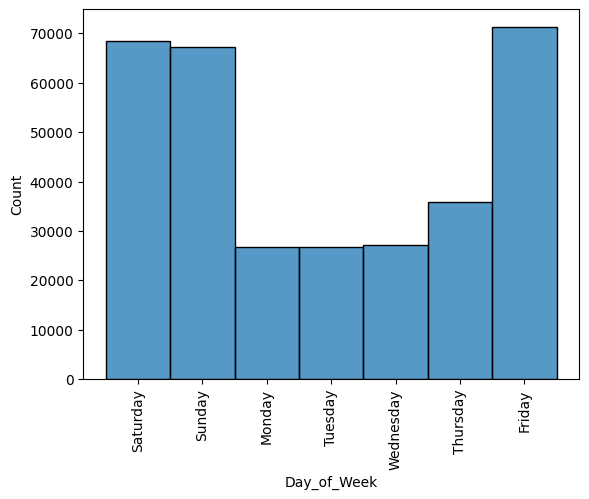

In [ ]:
# Days of the week distribution
plt.xticks(rotation=90)
sns.histplot(x='Day_of_Week', data=df)

<Axes: xlabel='Income Range', ylabel='Count'>

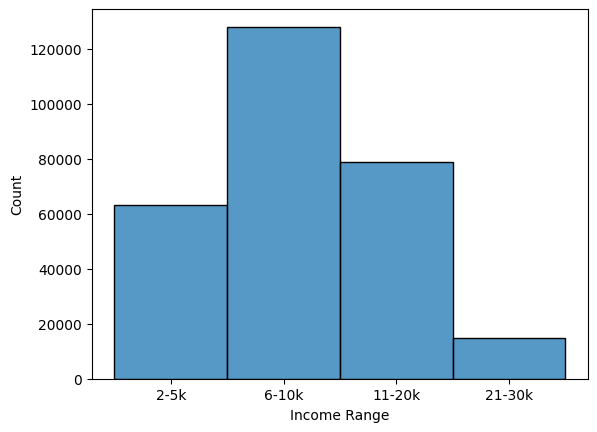

In [ ]:
# Income Range distribution
sns.histplot(x='Income Range', data=df)

In [ ]:
# Line plot for Cost of Trip(MonthYear)

# Rotate x-axis labels
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)

sns.lineplot(x='MonthYear', y='Cost of Trip', hue='Company', data=df)

In [ ]:
# Line plot for amount charged by company(MonthYear)

# Rotate x-axis labels
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)

sns.lineplot(x='MonthYear', y='Price Charged', hue='Company', data=df)


In [ ]:
# Line plot for Distance travelled by company(Monthyear)

# Rotate x-axis labels
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)

sns.lineplot(x='MonthYear', y='KM Travelled', hue='Company', data=df)

In [ ]:
# Line plot for Profit made over by company (MonthYear)

# Rotate x-axis labels
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)

sns.lineplot(x='MonthYear', y='Profit', hue='Company', data=df)

In [ ]:
# Line plot for distance travelled by year
sns.lineplot(x='Year', y='KM Travelled', hue='Company', data=df)

In [ ]:
# Line plot for profit by year
sns.lineplot(x='Year', y='Profit', hue='Company', data=df)

In [ ]:
# Line plot for distance travelled by month
plt.xticks(rotation=90)
sns.lineplot(x='Month', y='KM Travelled', hue='Company', data=df)


In [ ]:
# Line plot for profit by month
plt.xticks(rotation=90)
sns.lineplot(x='Month', y='Profit', hue='Company', data=df)

In [ ]:
# Line plot for distance travelled by day of the week
plt.xticks(rotation=90)
sns.lineplot(x='Day_of_Week', y='KM Travelled', hue='Company', data=df)

In [ ]:
# Line plot for profit made by day of the week
plt.xticks(rotation=90)
sns.lineplot(x='Day_of_Week', y='Profit', hue='Company', data=df)

## Forecasting Future Profit

In [ ]:
pink_cab_profit
yellow_cab_profit

# Split into training and testing sets (80% training, 20% testing)
# pink_train_size = int(len(pink_cab_profit) * 0.8)
# pink_train_set, pink_test_set = pink_cab_profit[:pink_train_size], pink_cab_profit[pink_train_size:]

# yellow_train_size = int(len(yellow_cab_profit) * 0.8)
# yellow_train_set, yellow_test_set = yellow_cab_profit[:yellow_train_size], yellow_cab_profit[pink_train_size:]

In [ ]:
# Create and fit the model on the training set
model = Prophet(interval_width=0.95)
model.fit(pink_cab_profit)

# Create a DataFrame for future dates (including both training and testing)
pink_future_profit = model.make_future_dataframe(periods=365)

# Make predictions
pink_forecast = model.predict(pink_future_profit)


In [ ]:
pink_forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']]
pink_cab_profit[['yhat', 'yhat_upper', 'yhat_lower']] = pink_forecast[['yhat', 'yhat_upper', 'yhat_lower']]
pink_cab_profit

In [ ]:
# Line plot for true Pink cab profit
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
pink_cab_profit.columns = ['Date', 'True Pink Cab Profit', 'Predicted Pink Cab Profit', 'yhat_upper', 'yhat_lower']
sns.lineplot(x='Date', y='True Pink Cab Profit', data=pink_cab_profit)

<Axes: xlabel='Date', ylabel='Predicted Pink Cab Profit'>

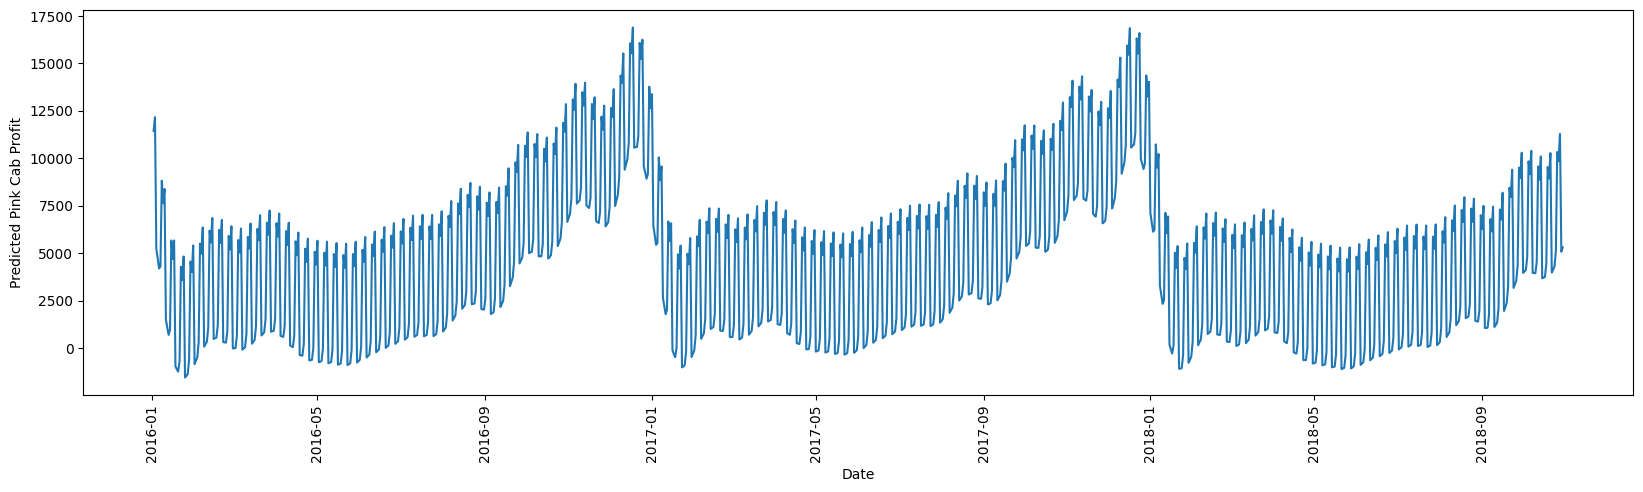

In [ ]:
# Line plot for predicted pink cab profit
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
sns.lineplot(x='Date', y='Predicted Pink Cab Profit', data=pink_cab_profit)

In [ ]:
# Create and fit the model on the training set
model = Prophet(interval_width=0.95)
model.fit(yellow_cab_profit)

# Create a DataFrame for future dates (including both training and testing)
yellow_future_profit = model.make_future_dataframe(periods=365)
yellow_forecast = model.predict(yellow_future_profit)


In [ ]:
# Yellow cab profit DataFrame(true and predicted)
yellow_forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']]
yellow_cab_profit[['yhat', 'yhat_upper', 'yhat_lower']] = yellow_forecast[['yhat', 'yhat_upper', 'yhat_lower']]
yellow_cab_profit

In [ ]:
# Line plot for true Yellow cab profit
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
yellow_cab_profit.columns = ['Date', 'True Yellow Cab Profit', 'Predicted Yellow Cab Profit', 'yhat_upper', 'yhat_lower']
sns.lineplot(x='Date', y='True Yellow Cab Profit', data=yellow_cab_profit)

<Axes: xlabel='Date', ylabel='Predicted Yellow Cab Profit'>

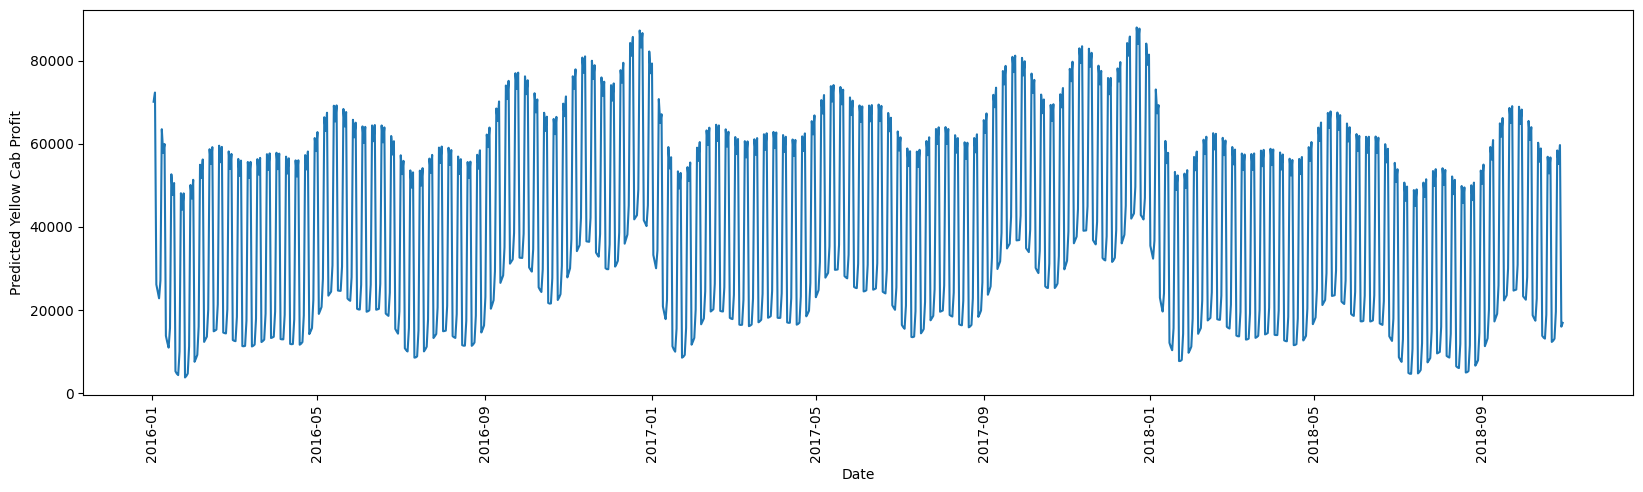

In [ ]:
# Line plot for predicted yellow cab profit
plt.figure(figsize=(20,5))
plt.xticks(rotation=90)
sns.lineplot(x='Date', y='Predicted Yellow Cab Profit', data=yellow_cab_profit)

,Date,"Pink Cab Oct,2018 - Oct, 2019 Profit"
1033,2018-10-31,5532.95
1034,2018-11-01,6373.58
1035,2018-11-02,11601.11
1036,2018-11-03,11101.34
1037,2018-11-04,12505.03
...,...,...
1393,2019-10-26,8174.50
1394,2019-10-27,9603.21
1395,2019-10-28,3391.54
1396,2019-10-29,3610.67


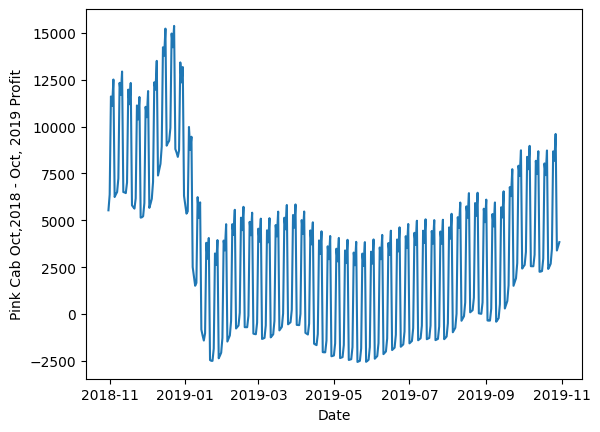

In [ ]:
#DataFrame for Oct 2018 to Oct 2019 prediction
pink_next_year_profit = pink_forecast[-365:][['ds','yhat']]
yellow_next_year_profit = yellow_forecast[-365:][['ds','yhat']]
yellow_next_year_profit.columns = ['Date', 'Yellow Cab Oct,2018 - Oct, 2019 Profit']
pink_next_year_profit.columns = ['Date', 'Pink Cab Oct,2018 - Oct, 2019 Profit']

# Line plot for pink cab future profit
sns.lineplot(x='Date', y='Pink Cab Oct,2018 - Oct, 2019 Profit', data=pink_next_year_profit)
pink_next_year_profit

<Axes: xlabel='Date', ylabel='Yellow Cab Oct,2018 - Oct, 2019 Profit'>

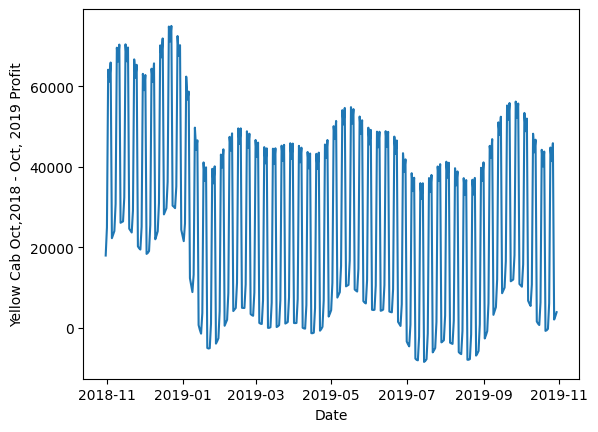

In [ ]:
#Line plot for yellow future profit
sns.lineplot(x='Date', y='Yellow Cab Oct,2018 - Oct, 2019 Profit', data=yellow_next_year_profit)